In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Input, Merge
from keras import backend as K
from keras.constraints import Constraint
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.decomposition import PCA
import pickle
from keras.engine.topology import Layer

/home/jsk/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [84]:
queryset = np.load('query_data.npz')
x_query = queryset['x_query'].T
y_query = queryset['y_query']

def binarize_data(x_train):
    x_train_new = np.copy(x_train)
    x_train_new[x_train_new != 0] = 1.0
    return x_train_new

lab_dict = pickle.load(open('lab_dict.pkl'))
idx2lab = pickle.load(open('idx2lab.pkl'))
lab2idx = pickle.load(open('lab2idx.pkl'))

whole = np.load('whole_eval_data.npz')
x_eval = whole['x_eval'][:-1, :]
y_eval = whole['y_eval'][:-1]

x_query = binarize_data(x_query)
x_eval = binarize_data(x_eval)
del queryset, whole

In [3]:
label_encoder = json.load(open('label_encoder_eval.json', 'r'))
label_decoder = json.load(open('label_decoder_eval.json', 'r'))
feature_encoder = json.load(open('feature_encoder_eval.json', 'r'))
feature_decoder = json.load(open('feature_decoder_eval.json', 'r'))
dim = len(feature_encoder.keys())

class GroupLayer(Layer):
    def __init__(self, output_dim, mask, **kwargs):
        self.output_dim = output_dim
        self.mask = mask
        super(GroupLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
        super(GroupLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return K.dot(x, self.kernel * self.mask)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


In [4]:
ppi = pd.read_csv('data/ppi_tf_merge_cluster.csv', sep='\t', header=None)

data = np.load('supervised_train.npz')
x_train_raw, y_train = data['x_train'], data['y_train']
def binarize_data(x_train):
    x_train_new = np.copy(x_train)
    x_train_new[x_train_new != 0] = 1.0
    return x_train_new

x_train_bin = binarize_data(x_train_raw)

names = list(ppi[0].as_matrix())
tf_idx = [i for i in range(len(names)) if 'TF:' in names[i]]
pp_idx = [i for i in range(len(names)) if 'TF:' not in names[i]]
tf_only = ppi.loc[tf_idx, :].as_matrix()
pp_only = ppi.loc[pp_idx, :].as_matrix()

# Convert the TF and PPI info to dictionary
tf_names = [n[4:] for n in names if 'TF:' in n]
tf_info = dict()
for i, n in enumerate(tf_names):
    tf_info[n] = [feature_encoder[d] for d in list(tf_only[i])[1:] if type(d) == str]
    
pp_info = dict()
for l in range(pp_only.shape[0]):
    pp_info[l] = [feature_encoder[d] for d in list(pp_only[l])[1:] if type(d) == str]
    
tf_nz_idx = []
for i in range(dim):
    for j in range(348):
        if i in tf_info[tf_info.keys()[j]]:
            tf_nz_idx.append((i,j))
            
pp_nz_idx = []
for i in range(dim):
    for j in range(348):
        if i in pp_info[j]:
            pp_nz_idx.append((i,j))
            
tf_mask = np.zeros((dim, 348))
pp_mask = np.zeros((dim, 348))
for (i, j) in tf_nz_idx:
    tf_mask[i,j] = 1.0
for (i, j) in pp_nz_idx:
    pp_mask[i,j] = 1.0

del ppi

In [6]:
num_classes = np.unique(y_train).shape[0]

## 2 layer FC NN base-nn
base_model = Sequential()
base_model.add(Dense(units=200, input_dim=x_train_bin.shape[1], name='fc1'))
base_model.add(Activation('tanh'))
base_model.add(Dense(units=200, name='fc2'))
base_model.add(Activation('tanh'))
base_model.add(Dense(units=num_classes, name='output'))
base_model.add(Activation('softmax'))
base_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.99),
              metrics=['accuracy'])
#one hot encode y_train
one_hot_targets = np.eye(num_classes)[y_train]
base_model.fit(x_train_bin, one_hot_targets, epochs=100, batch_size=64)
train_loss_acc = base_model.evaluate(x_train_bin, one_hot_targets, batch_size=64)

## bio-nn
dense1 = Sequential()
dense1.add(Dense(units=50, input_dim=dim))
tf_nodes = Sequential()
tf_nodes.add(GroupLayer(348, tf_mask, input_shape=(dim, ), name='tfnode'))
pp_nodes = Sequential()
pp_nodes.add(GroupLayer(348, pp_mask, input_shape=(dim, ), name='ppnode'))

bio_model = Sequential()
bio_model.add(Merge([dense1, tf_nodes, pp_nodes], mode = 'concat'))
bio_model.add(Activation('tanh'))
bio_model.add(Dense(units=200, name='fc2'))
bio_model.add(Activation('tanh'))
bio_model.add(Dense(units=num_classes, name='output'))
bio_model.add(Activation('softmax'))
bio_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.99),
              metrics=['accuracy'])
one_hot_targets = np.eye(num_classes)[y_train]
bio_model.fit([x_train_bin, x_train_bin, x_train_bin], one_hot_targets, epochs=100, batch_size=64)


## PCA
pca = PCA(n_components=200)
pca.fit(x_train_bin)

## Semi

autoencoder = load_model('autoencoder.h5')
[w1, b1] = autoencoder.layers[1].get_weights()
[w2, b2] = autoencoder.layers[2].get_weights()
semi_model = Sequential()
semi_model.add(Dense(units=200, input_dim=dim, name='fc1'))
semi_model.add(Activation('tanh'))
semi_model.add(Dense(units=200, name='fc2'))
semi_model.add(Activation('tanh'))
semi_model.add(Dense(units=num_classes, name='output'))
semi_model.add(Activation('softmax'))
# initialize the weights
semi_model.layers[0].set_weights([w1, b1])
semi_model.layers[2].set_weights([w2, b2])
semi_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.99),
              metrics=['accuracy'])

one_hot_targets = np.eye(num_classes)[y_train]
semi_model.fit(x_train_bin, one_hot_targets, epochs=200, batch_size=64)

Epoch 1/100
402/402 [==============================] - 0s 270us/step - loss: 2.7892 - acc: 0.0970
Epoch 2/100
402/402 [==============================] - 0s 65us/step - loss: 2.3434 - acc: 0.2761
Epoch 3/100
402/402 [==============================] - 0s 61us/step - loss: 1.9964 - acc: 0.3731
Epoch 4/100
402/402 [==============================] - 0s 62us/step - loss: 1.6289 - acc: 0.5249
Epoch 5/100
402/402 [==============================] - 0s 61us/step - loss: 1.2669 - acc: 0.7164
Epoch 6/100
402/402 [==============================] - 0s 67us/step - loss: 1.0460 - acc: 0.7040
Epoch 7/100
402/402 [==============================] - 0s 66us/step - loss: 0.8400 - acc: 0.7886
Epoch 8/100
402/402 [==============================] - 0s 57us/step - loss: 0.6864 - acc: 0.8905
Epoch 9/100
402/402 [==============================] - 0s 66us/step - loss: 0.5808 - acc: 0.8881
Epoch 10/100
402/402 [==============================] - 0s 60us/step - loss: 0.4716 - acc: 0.9502
Epoch 11/100
402/402 [======

402/402 [==============================] - 0s 60us/step - loss: 7.4083e-04 - acc: 1.0000
Epoch 85/100
402/402 [==============================] - 0s 58us/step - loss: 7.2956e-04 - acc: 1.0000
Epoch 86/100
402/402 [==============================] - 0s 59us/step - loss: 7.1867e-04 - acc: 1.0000
Epoch 87/100
402/402 [==============================] - 0s 61us/step - loss: 7.0912e-04 - acc: 1.0000
Epoch 88/100
402/402 [==============================] - 0s 59us/step - loss: 6.9964e-04 - acc: 1.0000
Epoch 89/100
402/402 [==============================] - 0s 57us/step - loss: 6.9047e-04 - acc: 1.0000
Epoch 90/100
402/402 [==============================] - 0s 59us/step - loss: 6.8167e-04 - acc: 1.0000
Epoch 91/100
402/402 [==============================] - 0s 59us/step - loss: 6.7349e-04 - acc: 1.0000
Epoch 92/100
402/402 [==============================] - 0s 58us/step - loss: 6.6532e-04 - acc: 1.0000
Epoch 93/100
402/402 [==============================] - 0s 59us/step - loss: 6.5786e-04 - acc: 

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


402/402 [==============================] - 0s 591us/step - loss: 2.7086 - acc: 0.1294
Epoch 2/100
402/402 [==============================] - 0s 160us/step - loss: 2.4729 - acc: 0.1741
Epoch 3/100
402/402 [==============================] - 0s 159us/step - loss: 2.3570 - acc: 0.2637
Epoch 4/100
402/402 [==============================] - 0s 151us/step - loss: 2.1928 - acc: 0.3109
Epoch 5/100
402/402 [==============================] - 0s 147us/step - loss: 2.0123 - acc: 0.3483
Epoch 6/100
402/402 [==============================] - 0s 150us/step - loss: 1.8075 - acc: 0.4527
Epoch 7/100
402/402 [==============================] - 0s 151us/step - loss: 1.6218 - acc: 0.5323
Epoch 8/100
402/402 [==============================] - 0s 146us/step - loss: 1.4412 - acc: 0.5672
Epoch 9/100
402/402 [==============================] - 0s 151us/step - loss: 1.2603 - acc: 0.6418
Epoch 10/100
402/402 [==============================] - 0s 156us/step - loss: 1.0921 - acc: 0.7612
Epoch 11/100
402/402 [=========

Epoch 84/100
402/402 [==============================] - 0s 149us/step - loss: 0.0019 - acc: 1.0000
Epoch 85/100
402/402 [==============================] - 0s 148us/step - loss: 0.0019 - acc: 1.0000
Epoch 86/100
402/402 [==============================] - 0s 146us/step - loss: 0.0018 - acc: 1.0000
Epoch 87/100
402/402 [==============================] - 0s 152us/step - loss: 0.0018 - acc: 1.0000
Epoch 88/100
402/402 [==============================] - 0s 151us/step - loss: 0.0018 - acc: 1.0000
Epoch 89/100
402/402 [==============================] - 0s 155us/step - loss: 0.0017 - acc: 1.0000
Epoch 90/100
402/402 [==============================] - 0s 152us/step - loss: 0.0017 - acc: 1.0000
Epoch 91/100
402/402 [==============================] - 0s 156us/step - loss: 0.0017 - acc: 1.0000
Epoch 92/100
402/402 [==============================] - 0s 158us/step - loss: 0.0017 - acc: 1.0000
Epoch 93/100
402/402 [==============================] - 0s 160us/step - loss: 0.0016 - acc: 1.0000
Epoch 94/1

402/402 [==============================] - 0s 64us/step - loss: 0.0048 - acc: 1.0000
Epoch 151/200
402/402 [==============================] - 0s 65us/step - loss: 0.0047 - acc: 1.0000
Epoch 152/200
402/402 [==============================] - 0s 61us/step - loss: 0.0047 - acc: 1.0000
Epoch 153/200
402/402 [==============================] - 0s 63us/step - loss: 0.0046 - acc: 1.0000
Epoch 154/200
402/402 [==============================] - 0s 65us/step - loss: 0.0046 - acc: 1.0000
Epoch 155/200
402/402 [==============================] - 0s 62us/step - loss: 0.0046 - acc: 1.0000
Epoch 156/200
402/402 [==============================] - 0s 63us/step - loss: 0.0045 - acc: 1.0000
Epoch 157/200
402/402 [==============================] - 0s 60us/step - loss: 0.0045 - acc: 1.0000
Epoch 158/200
402/402 [==============================] - 0s 60us/step - loss: 0.0045 - acc: 1.0000
Epoch 159/200
402/402 [==============================] - 0s 58us/step - loss: 0.0044 - acc: 1.0000
Epoch 160/200
402/402 [=

In [86]:
base_feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
bio_feature_model = Model(inputs=bio_model.input, outputs=bio_model.get_layer('fc2').output)    
semi_feature_model = Model(inputs=semi_model.input, outputs=semi_model.get_layer('fc2').output)

pca_features = pca.transform(x_eval)
base_feature = base_feature_model.predict(x_eval)
bio_feature = bio_feature_model.predict([x_eval, x_eval, x_eval])
semi_feature = semi_feature_model.predict(x_eval)

In [104]:
from sklearn.manifold import TSNE

model_names = ['semi-nn', 'bio-nn', 'pca', 'base-nn']
feature_outs = [semi_feature, bio_feature, pca_features, base_feature]
domain = ['HSC', '4cell', 'ICM', 'spleen', '8cell', 'neuron', 'zygote', '2cell', 'ESC']
domain_info = [range(18, 26), [5,6,7], range(27, 30), [65], [8,9], range(58, 63), [72,73], [2, 3, 4], range(10, 18)]
new_map = dict()
new_decoder = dict()
for i, d in enumerate(domain_info):
    for elem in d:
        new_map[elem] = i
    new_decoder[i] = domain[i]
new_labels = np.array([new_map[y] if y in new_map.keys() else -1  for y in y_eval])

fig_idx = [(0,0), (0,1), (1,0), (1,1)]



In [107]:
np.unique(new_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [96]:
tsne_outputs = []
for m, f in zip(model_names, feature_outs):
    print(m)
    X_embedded = TSNE(n_components=2).fit_transform(f)
    tsne_outputs.append(X_embedded)

semi-nn
bio-nn
pca
base-nn


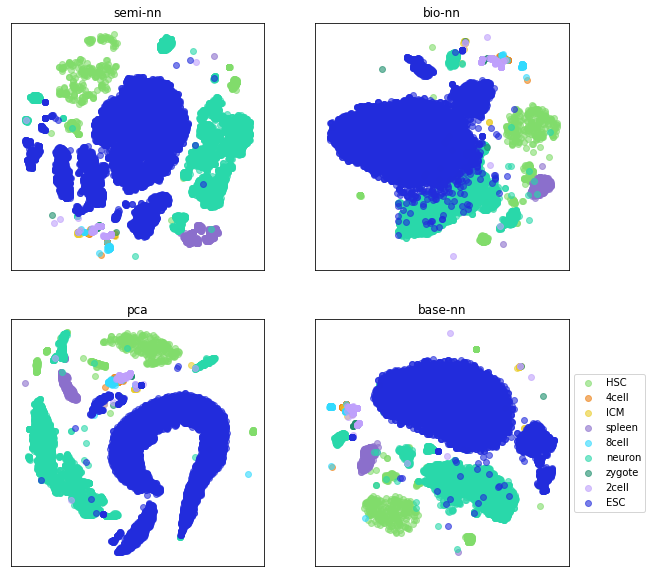

In [111]:
# Plt TSNE results
colors = []
for i in range(len(np.unique(new_labels))):
    np.random.seed(i*71)
    colors.append('#%06X' %np.random.randint(0, 0xFFFFFF))

f, axs = plt.subplots(2,2, figsize=(10, 10))
count = 0
for m, f, X in zip(model_names, feature_outs, tsne_outputs):
    ax = axs[fig_idx[count][0], fig_idx[count][1]]
    for l, c in zip(np.unique(new_labels), colors):
        if l != -1:
            ax.scatter(X[new_labels == l, 0], X[new_labels == l, 1], c=c, label=new_decoder[l], alpha=0.6)
    ax.set_title(m)
    ax.set_xticks(())
    ax.set_yticks(())
    count += 1
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [87]:
#Queried from query and retrieved from eval

def compute_distance(train_feature, queried, metric='l2'):
    row, col = train_feature.shape
    tiled = np.tile(queried, (row, 1))
    if metric == 'l1':
        dist = np.linalg.norm(train_feature - tiled, ord=1, axis=1)
    elif metric == 'l2':
        dist = np.linalg.norm(train_feature - tiled, ord=2, axis=1)
    return dist

def retrieve_from_eval(idx, feature_type = 'base', top_k=10):
    input_ = np.expand_dims(x_query[idx,:],0)
    if feature_type == 'base':
        queried = base_feature_model.predict(input_)[0]
        dist = compute_distance(base_feature, queried, metric='l2')
    elif feature_type == 'pca':
        queried = pca.transform(input_)
        dist = compute_distance(pca_features, queried, metric='l2')
    elif feature_type == 'semi':
        queried = semi_feature_model.predict(input_)[0]
        dist = compute_distance(semi_feature, queried, metric='l2')
    elif feature_type == 'bio':
        queried = bio_feature_model.predict([input_, input_, input_])[0]
        dist = compute_distance(bio_feature, queried, metric='l2')
    lab_no = idx2lab[idx]
    # do not retrieve from the same lab.
    idx_to_skip = range(lab_dict[lab_no][0], lab_dict[lab_no][1])
    dist[idx_to_skip] = np.inf
    rank_close = np.argsort(dist)
    return rank_close[:top_k]

def computeAP(ranked_idx):
    groups_predicted = [label_decoder[str(y_eval[i])].split('_')[0] for i in ranked_idx]
    true_group = label_decoder[str(y_query[idx])].split('_')[0]
    #print(true_group, groups_predicted)
    correct = [1 if x == true_group else 0 for x in groups_predicted] # list of 1s and 0s
    
    obs = []
    for i in range(len(ranked_idx)):
        if correct[i] == 0:
            obs.append(0)
        else:
            obs.append(np.sum(correct[:i+1]) / float(i+1))
    return np.sum(obs) / np.sum(correct)
    

In [144]:
# Query 100 times randomly for each domains and compute MAP
K = 10
domain = ['HSC', '4cell', 'ICM', 'spleen', '8cell', 'neuron', 'zygote', '2cell', 'ESC']
domain_info = [range(18, 26), [5,6,7], range(27, 30), [65], [8,9], range(58, 63), [72,73], [2, 3, 4], range(10, 18)]
domain_results = dict()
group_idx = dict()
for d in domain:
    cell_types = label_encoder.keys()
    filtered = [c for c in cell_types if d in c]
    group_idx[d] = sorted([label_encoder[x] for x in filtered])

for domain_name, d_range in zip(domain, domain_info):
    print(domain_name)
    bio_val = 0.
    semi_val = 0.
    pca_val = 0.
    base_val = 0.
    
    selected = [i for i in range(len(y_query)) if y_query[i] in group_idx[domain_name]]
    num_query = len(selected)
    print(num_query)
    for idx in selected:
        #label_int = np.random.choice(d_range)
        #idx = np.random.choice(np.where(y_query == label_int)[0])
        rank_base = retrieve_from_eval(idx, feature_type = 'base', top_k=K)
        rank_semi = retrieve_from_eval(idx, feature_type = 'semi', top_k=K)
        rank_bio = retrieve_from_eval(idx, feature_type = 'bio', top_k=K)
        rank_pca = retrieve_from_eval(idx, feature_type = 'pca', top_k=K)
        base_ap = computeAP(rank_base)
        semi_ap = computeAP(rank_semi)
        bio_ap = computeAP(rank_bio)
        pca_ap = computeAP(rank_pca)
        bio_val += bio_ap
        semi_val += semi_ap
        pca_val += pca_ap
        base_val += base_ap
    domain_results[domain_name] = [bio_val/num_query, semi_val/num_query, pca_val/num_query, base_val/num_query]
        
        
    

HSC
468
4cell
55


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in long_scalars


ICM
22
spleen
420
8cell
53
neuron
3667
zygote
18
2cell
85
ESC
9123


In [145]:
print('Cell Type & bio-nn & semi-nn & pca & base-nn \\ \hline')
for k in domain_results.keys():
    vals = domain_results[k]
    print("%s & %0.3f & %0.3f & %0.3f & %0.3f \\\ "%(k, vals[0], vals[1], vals[2], vals[3]))

Cell Type & bio-nn & semi-nn & pca & base-nn \ \hline
HSC & 0.862 & 0.874 & 0.884 & 0.878 \\ 
4cell & 0.853 & 0.823 & 0.849 & 0.777 \\ 
ICM & 0.802 & 0.796 & 0.880 & 0.858 \\ 
spleen & 0.989 & 0.997 & 0.997 & 0.983 \\ 
8cell & 0.111 & 0.102 & 0.105 & 0.105 \\ 
neuron & 0.991 & 0.997 & 0.995 & 0.989 \\ 
zygote & 0.902 & 0.940 & 0.938 & 0.940 \\ 
2cell & 0.753 & 0.667 & 0.746 & 0.802 \\ 
ESC & 0.596 & 0.585 & 0.589 & 0.621 \\ 


In [146]:
avg = np.zeros(4)
for k in domain_results.keys():
    vals = domain_results[k]
    avg[0] += vals[0]
    avg[1] += vals[1]
    avg[2] += vals[2]
    avg[3] += vals[3]
print(avg / 9.0)

[0.76202547 0.75358695 0.77592621 0.77257269]
